# TP1
The goal of this first practical work is to experiment the estimation of second order moments for
random processes, and to simply compare them with their theoretical version. 

Let consider the following real processes:
-  White Noise (denoted $\text{WN}$) $Z_t$ with variance $\sigma^2$ (use `np.random.normal`)
-  $X_t=a+bZ_t+Z_{t-1}$ where $Z_t \sim \text{WN}\left(0,\sigma^2\right)$
- $X_t = \sum_{k=0}^{K}2^{-k}Z_{t-k} + a$ (with $K$ "big enough")
- Harmonic Process: $X_t=A_0\cos(\lambda_0t+\Phi_0)+Z_t$ where $\lambda \in [0,\pi[,$ $\Phi_0 \sim \mathcal{U}([0,2\pi])$ (*e.g.* `np.random.uniform`)

For each of them:
1. Compute the theoretical mean and autocovariance of the previous mentioned real processes using the formulas $\mathbb{E}(X_n)$ and $\mathrm{Cov}(X_{n},X_{n+h})$.
2. Compute their empirical mean and empirical autocovariance function using course's formulas in python.
3. Plot the theoretical operator and empirical estimators for various sampling many times and comment.
4. For a given number $ T \in \{10, 100, 500, 1000\}$ of samples $X_1, \dots, X_T$:
  - for a given draw, compute the mean squared error (MSE) $\frac{1}{T}\sum_t (\gamma_{t} - \hat{\gamma_{t}})^2$ between the theoretical and the empirical autocovariance function denoted $\gamma$ and $\hat{\gamma}$ respectively.
  - Repeat the previous step $100$ times and saves all the results.
  - compute the boxplot of the MSE for each $T$ and comment.





### Question 1 :

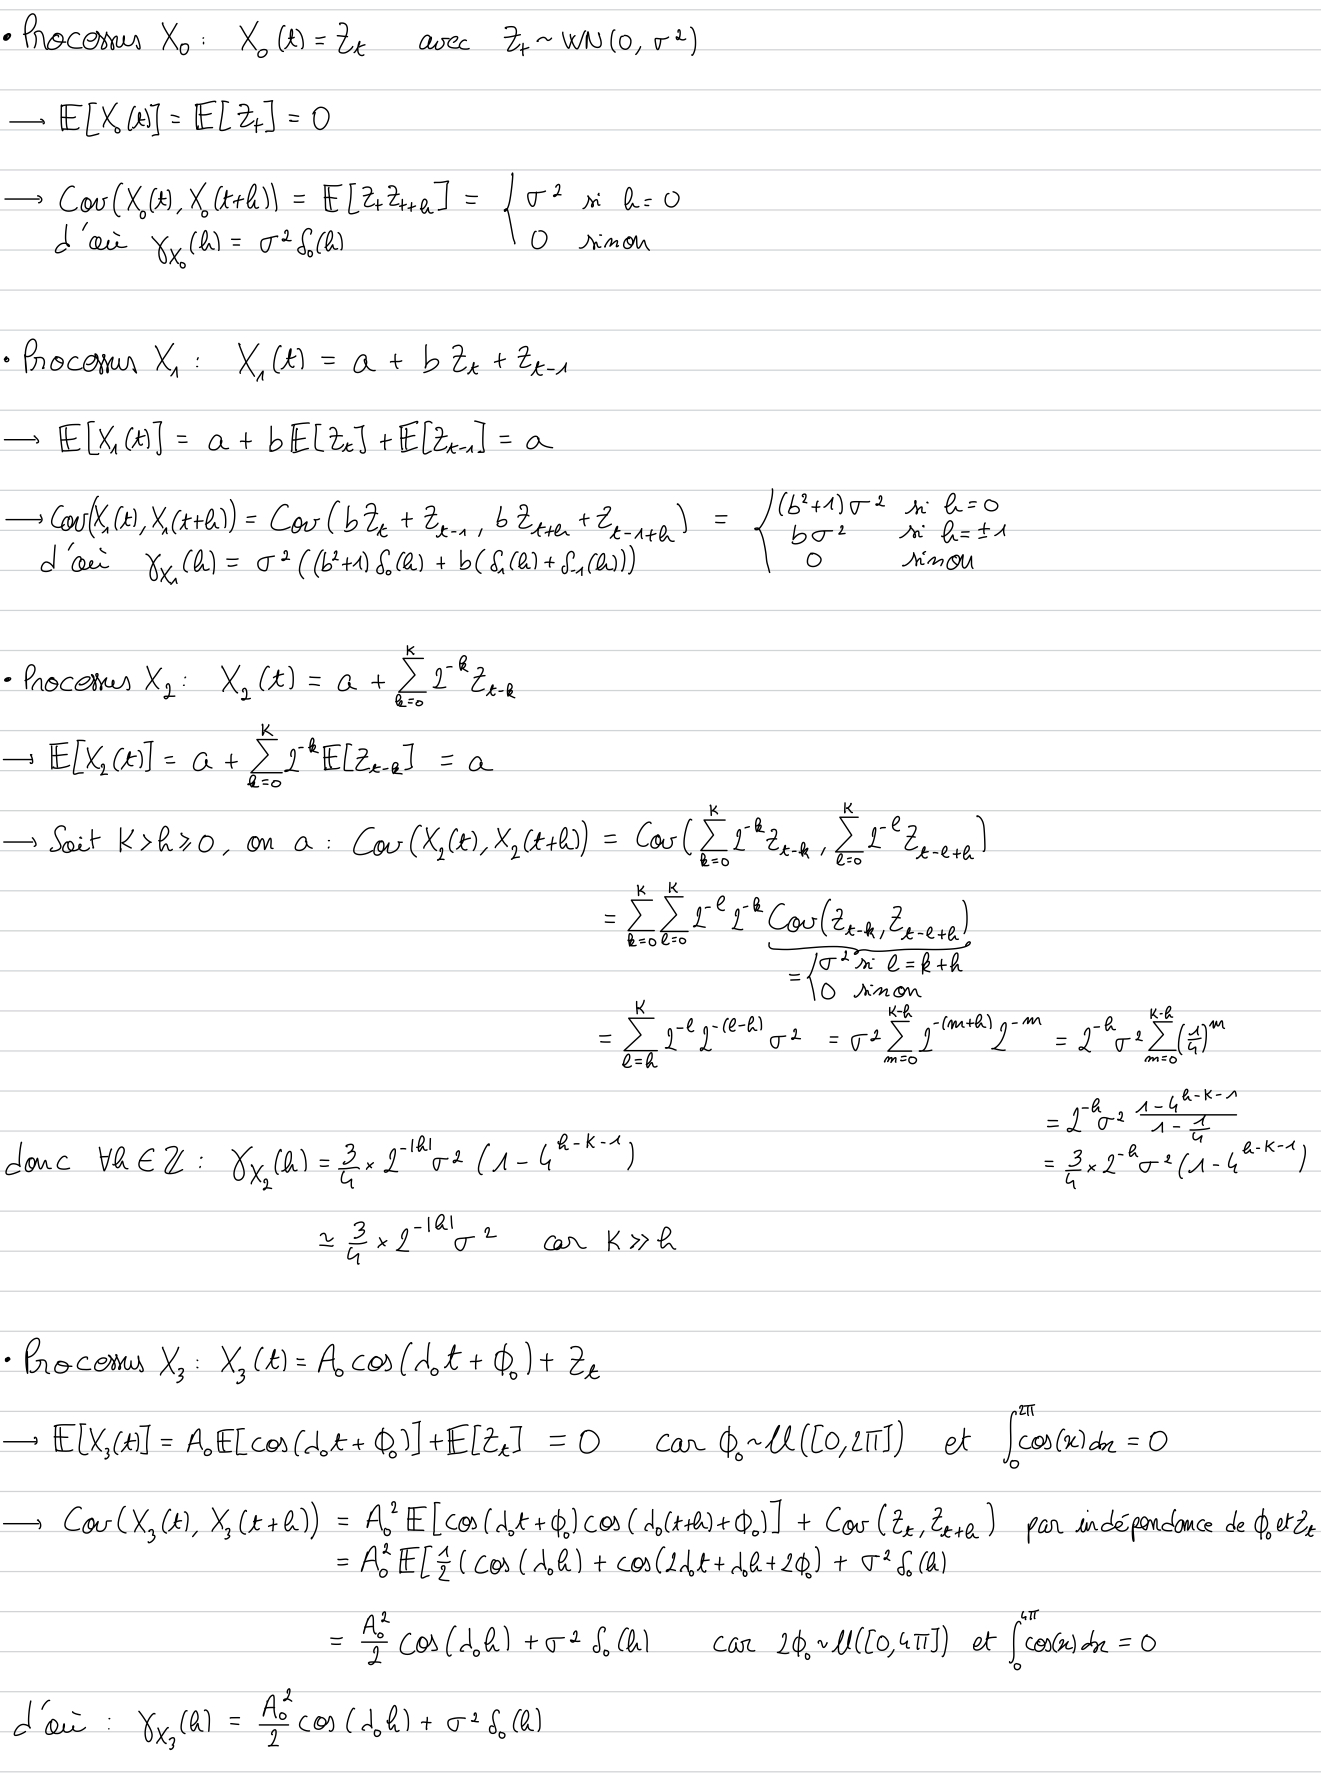

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n = 1000
sigma = 1
a = 3
b = 5
K = 10000 #K très grand
A0 = 2
lambda0 = np.pi/2 #compris entre 0 (inclu) et pi (strict)
num_sim = 100

In [3]:
def theorical_mean(process_index):
    theorical_means = [0,a,a,0]
    return theorical_means[process_index]

def theorical_autocov(process_index,h): #uniquement pour h=1 actuellement
    if h == 0:
        t= [sigma**2,(b**2+1)*sigma**2,4*(sigma**2)*(1-4**(-K-1))/3,(A0**2)/2 + sigma**2]
    elif h == 1:
        t = [0,b*sigma**2,2*(sigma**2)*(1-4**(-K))/3,(A0**2)*np.cos(lambda0)/2]
    else:
        t = [0,0,4*(sigma**2)*(2**(-h))*(1-4**(h-K-1))/3,(A0**2)*np.cos(lambda0*h)/2]
        if h > K:
            t[2] = 0
    return t[process_index]

### Question 2 :

In [4]:
def X0(sigma,n):
    return np.random.normal(0,sigma,n)

def X1(a,b,sigma,n):
    Z = X0(sigma,n+1)
    return a+b*Z[1:n+1]+Z[:n]

def X2(K,c,sigma,n):
    Z = X0(sigma,n+K)
    A = np.array([2**(-k) for k in range(K+1)])
    return np.array([np.sum(A*np.flip(Z[i:i+K+1])) for i in range(n)]) + c

def X3(A0,lambda0,sigma,n):
    assert 0 <= lambda0 < np.pi
    return A0*np.cos(np.array([lambda0*t for t in range(n)]) + np.random.uniform(0, 2 * np.pi)) + X0(sigma,n)

In [5]:
def mean(X):
    return np.sum(X)/len(X)

def autocov(x, h):
    n = len(x)
    mu = np.mean(x)
    return np.sum((x[:n-h] - mu) * np.conj(x[h:n] - mu)) / n

In [6]:
results = np.empty((num_sim, 4), dtype=object)
for sim in range(num_sim):
    X = [X0(sigma,n),X1(a,b,sigma,n),X2(K,a,sigma,n),X3(A0,lambda0,sigma,n)]
    for i in range(4):
        results[sim,i] = {'mean': mean(X[i]),'autocov': [autocov(X[i],h) for h in range(len(X[i]))]}

### Question 3 :

In [7]:
def plot(process_index,h_list):

    _, axs = plt.subplots(len(h_list)+1, 1, figsize=(10, 8))

    means = [results[sim, process_index]['mean'] for sim in range(num_sim)]

    axs[0].plot(means, label=f'Moyenne X{process_index}')
    theorical_mean_val = theorical_mean(process_index)
    axs[0].axhline(theorical_mean_val, color='red', linestyle='--', label=f'Moyenne théorique X{process_index}')
    axs[0].set_title(f"Moyenne pour le processus X{process_index}")
    axs[0].set_xlabel("Numéro simulation")
    axs[0].set_ylabel("Moyenne")
    axs[0].legend()

    for i, h in enumerate(h_list):
        autocovs = [results[sim, process_index]['autocov'][h] for sim in range(num_sim)]
        axs[i+1].plot(autocovs, label=f'Autocovariance X{process_index} h={h}')
        theorical_autocov_val = theorical_autocov(process_index, h)
        axs[i+1].axhline(theorical_autocov_val, color='red', linestyle='--', label=f'Autocovariance théorique h={h}')
        axs[i+1].set_title(f"Autocovariances pour le processus X{process_index} avec h={h_list[i]}")
        axs[i+1].set_xlabel("Numéro simulation")
        axs[i+1].set_ylabel("Autocovariance")
        axs[i+1].legend()

    plt.tight_layout()
    plt.show()

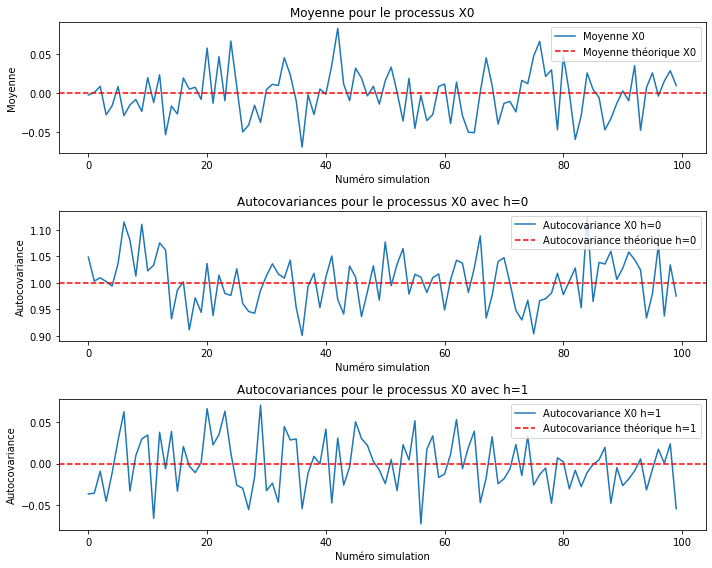

In [8]:
plot(0,[0,1])

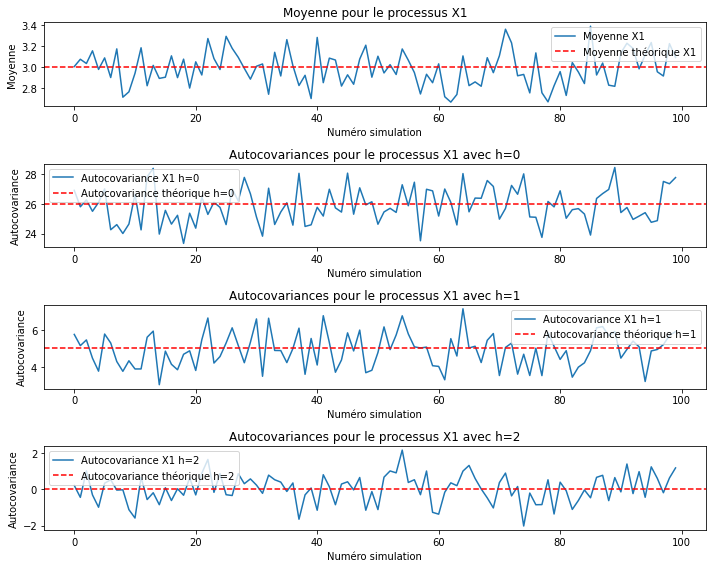

In [9]:
plot(1,[0,1,2])

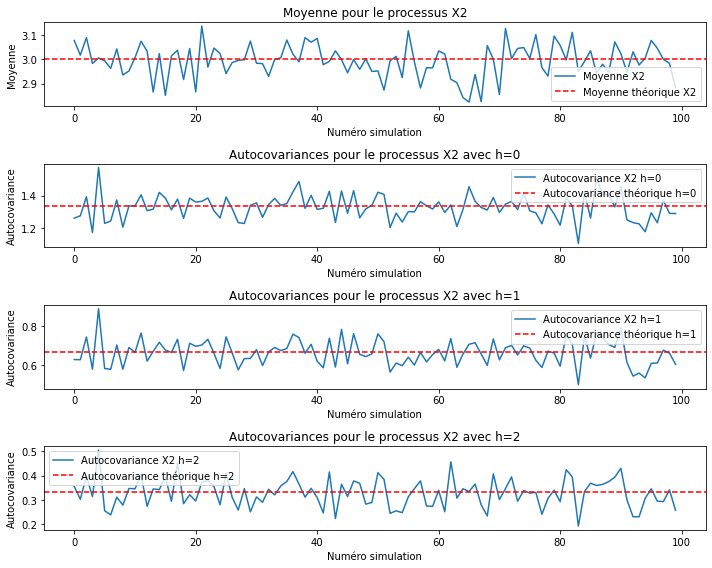

In [10]:
plot(2,[0,1,2])

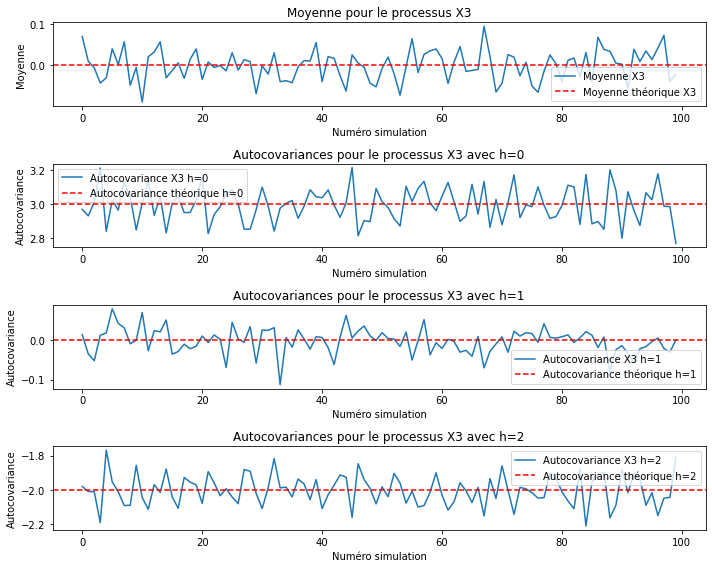

In [11]:
plot(3,[0,1,2])

On remarque que les valeurs d'autocovariances empiriques varient d'une simulation à l'autre mais qu'elles oscillent autour de la valeur théorique. On va chercher par la suite à quantifier ces écarts pour tout h en calculant la MSE entre l'autocovariance théorique et empirique. 

### Question 4 :

In [12]:
def MSE(X,process_index):
    T = len(X)
    theorical_autocovariance = np.array([theorical_autocov(process_index,h) for h in range(T)])
    empirical_autocovariance = np.array([autocov(X,h) for h in range(T)])
    return np.sum((theorical_autocovariance - empirical_autocovariance)**2)/T

T_list = [10,100,500,1000]
results_boxplot = np.zeros((len(T_list),100,4))
for t,T in enumerate(T_list):
    for k in range(100):
        results_boxplot[t,k] = np.array([MSE(X0(sigma,T),0),MSE(X1(a,b,sigma,T),1),MSE(X2(K,a,sigma,T),2),MSE(X3(A0,lambda0,sigma,T),3)])

def boxplot(process_index):
    mse_results = results_boxplot[:, :, process_index]

    plt.boxplot(mse_results.T, labels=T_list)
    plt.xlabel("Number of samples")
    plt.ylabel("MSE between theorical and empirical autocovariance")
    plt.title(f"Boxplot of autocovariance MSE for process X{process_index}")
    plt.show()

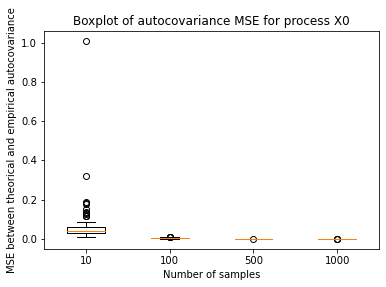

In [13]:
boxplot(0)

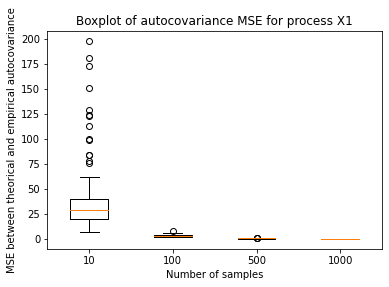

In [14]:
boxplot(1)

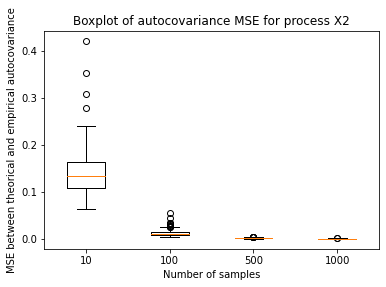

In [15]:
boxplot(2)

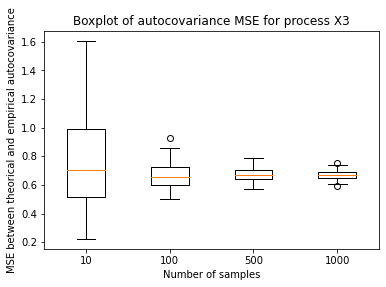

In [16]:
boxplot(3)

On remarque pour les 3 premiers processus que lorsqu'on augmente le nombre d'échantillons, la variance et la médiane des MSE diminue et tend vers 0. C'est une conséquence de la loi des grands nombres sur des processus faiblement stationnaire : en augmentant le nombre d'échantillons, on augmente le nombre de termes dans la somme de l'estimateur de l'autocovariance ce qui la fait tendre vers la valeur théorique et réduit sa variance d'une simulation à l'autre.

Le dernier processus a également un variance des MSE qui diminue lorsque l'on augmente le nombre d'échantillons mais sa médiane est quasiment inchangée. Cela s'explique par le fait que pour un processus harmonique, comme nous l'avons démontré dans la première question, a une autocovariance sinunoïdale de fréquence qui augmente avec h. C'est donc le seul des 4 processus dont l'autocovariance ne tend pas vers 0 lorsque h tend vers l'infini. Cependant l'estimateur de l'autocovariance se base sur de moins en moins de valeurs lorsque l'on augmente h, ainsi il est plus difficile d'estimer correctement la valeur théorique d'autocovariance pour de grandes valeurs de h. Les MSE du processus X3 sont donc de médiane et variance non nulle même lorsque l'on augmente grandement le nombre d'échantillons. Nous illustrons cela ici :

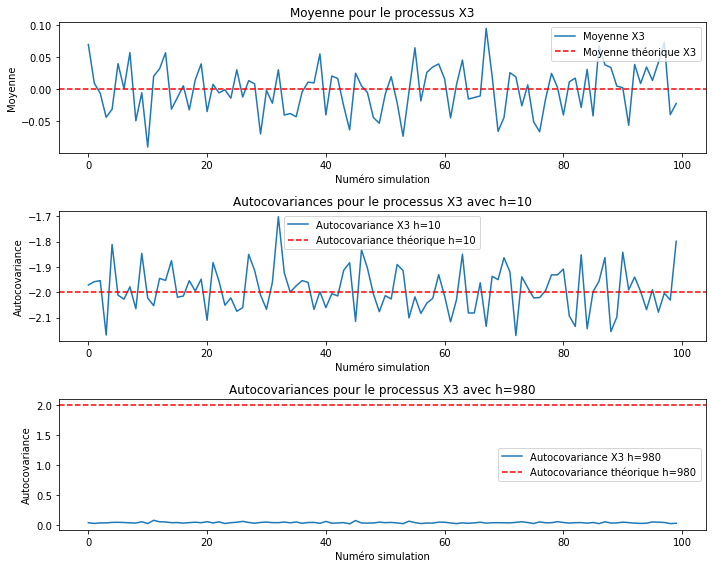

In [17]:
plot(3,[10,980])

# TP2
The goal of this second session is to provide a power spectral density estimator of a real, zero-mean, weakly stationary process $X_t$. We suppose that we have access to $n$ observations and we will use the FFT algorithm (that implements the DFT) using `numpy.fft.module`.
Recall (from the course) that the periodogram of the observations $X_0, \dots, X_{n-1}$ can be given as:
$$
I_n(\lambda) = \frac{1}{2\pi n}|\sum_{k=0}^{n-1} X_k e^{i\lambda k}|^2
$$

Moreover, the Hertglotz theorem provides a relation between the empirical autocovariance $\hat{\gamma}_n$ and the periodogram $I_n$:
$$
\hat{\gamma}_n(k) = \int_{0}^{2\pi}e^{i\lambda k}I_n({\lambda})d\lambda
$$

1. For a given $m \geq n$  we denote also the DFT as:
$$
DFT(X,m)(k) = \sum_{h=0}^{m-1}X_he^{-2i\pi\frac{kh}{m}}
$$
Show the following relation: 
$$I_n(\frac{2\pi k}{m}) = \frac{1}{2\pi n} |DFT(X,m)(k)|^2$$
2. provide a script that compute those $I_n(\frac{2\pi k}{m})$ for the time series mentioned in the first practice session
3. Show that $I_n(\lambda) = \frac{1}{2\pi} \sum_{k=0}^{n-1} \hat{\gamma}_n(k)e^{-i\lambda k}$
4. How to choose $m$ in order to get a simple relation between $\hat{\gamma}_n(k)$ and $I_n(\frac{2\pi k}{m})$ ? At the end, given a specific $\tilde{m}$ show that:
$$
\hat{\gamma}_n(k) = \frac{1}{n} IDFT\left(\left|DFT(X, \tilde{m})\right|^2, \tilde{m}\right)(k)
$$ Try this estimator on the autocovariance of previous time series of the first session.

5. In the case of white noise, estimate the variance of the periodogram for several values of $n$ and discuss about it.




### Question 1 :

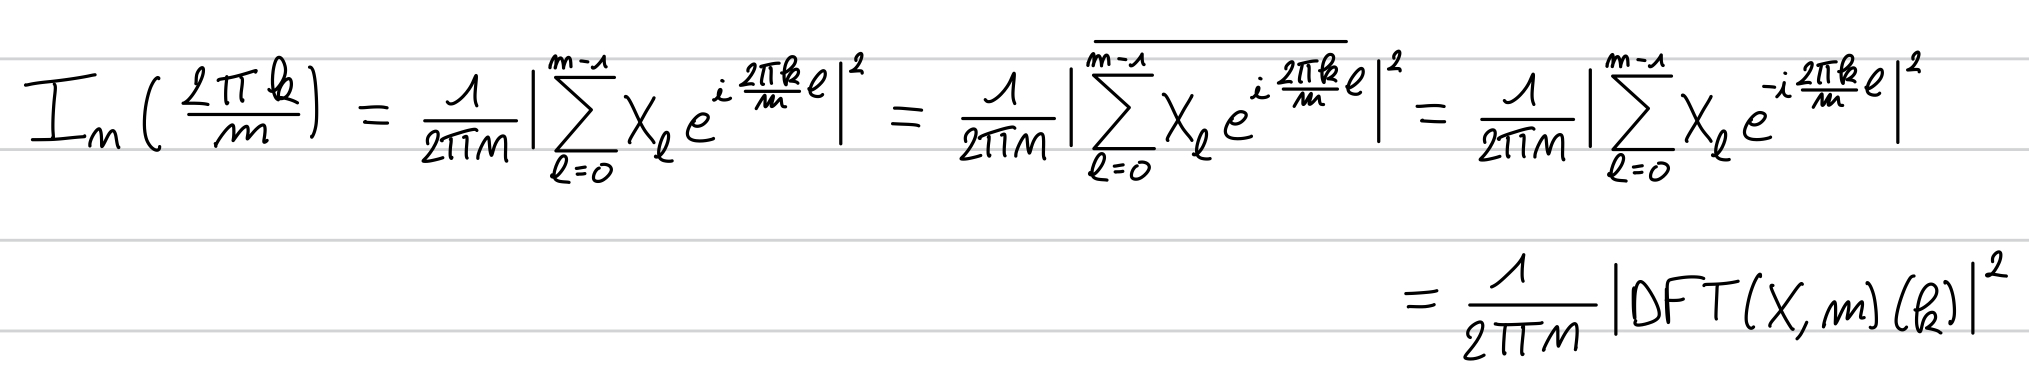

### Question 2:

In [18]:
import numpy as np
n = 1000
sigma = 1
a = 3
b = 5
c = 10
K = 10000 #K très grand
A0 = 2
lambda0 = np.pi/2 #compris entre 0 (inclu) et pi (strict)

m = 3000
k = 2000

In [19]:
def In(X,m,k):
    assert m >= len(X)
    assert k <= m
    return (abs(np.fft.fft(X - np.mean(X),m)[k])**2)/(2*np.pi*len(X))

def X0(sigma,n):
    return np.random.normal(0,sigma,n)

def X1(a,b,sigma,n):
    Z = X0(sigma,n+1)
    return a+b*Z[1:n+1]+Z[:n]

def X2(K,c,sigma,n):
    Z = X0(sigma,n+K)
    A = np.array([2**(-k) for k in range(K+1)])
    return np.array([np.sum(A*np.flip(Z[i:i+K+1])) for i in range(n)]) + c

def X3(A0,lambda0,sigma,n):
    assert 0 <= lambda0 < np.pi
    return A0*np.cos(np.array([lambda0*t for t in range(n)]) + np.random.uniform(0, 2 * np.pi)) + X0(sigma,n)

In [20]:
In_X0 = In(X0(sigma,n),m,k)
In_X1 = In(X1(a,b,sigma,n),m,k)
In_X2 = In(X2(K,c,sigma,n),m,k)
In_X3 = In(X3(A0,lambda0,sigma,n),m,k)

In [21]:
print(In_X0)
print(In_X1)
print(In_X2)
print(In_X3)

0.1877283152985991
0.5300583363291428
0.0313021857353555
0.11200294019940947


### Question 3 :

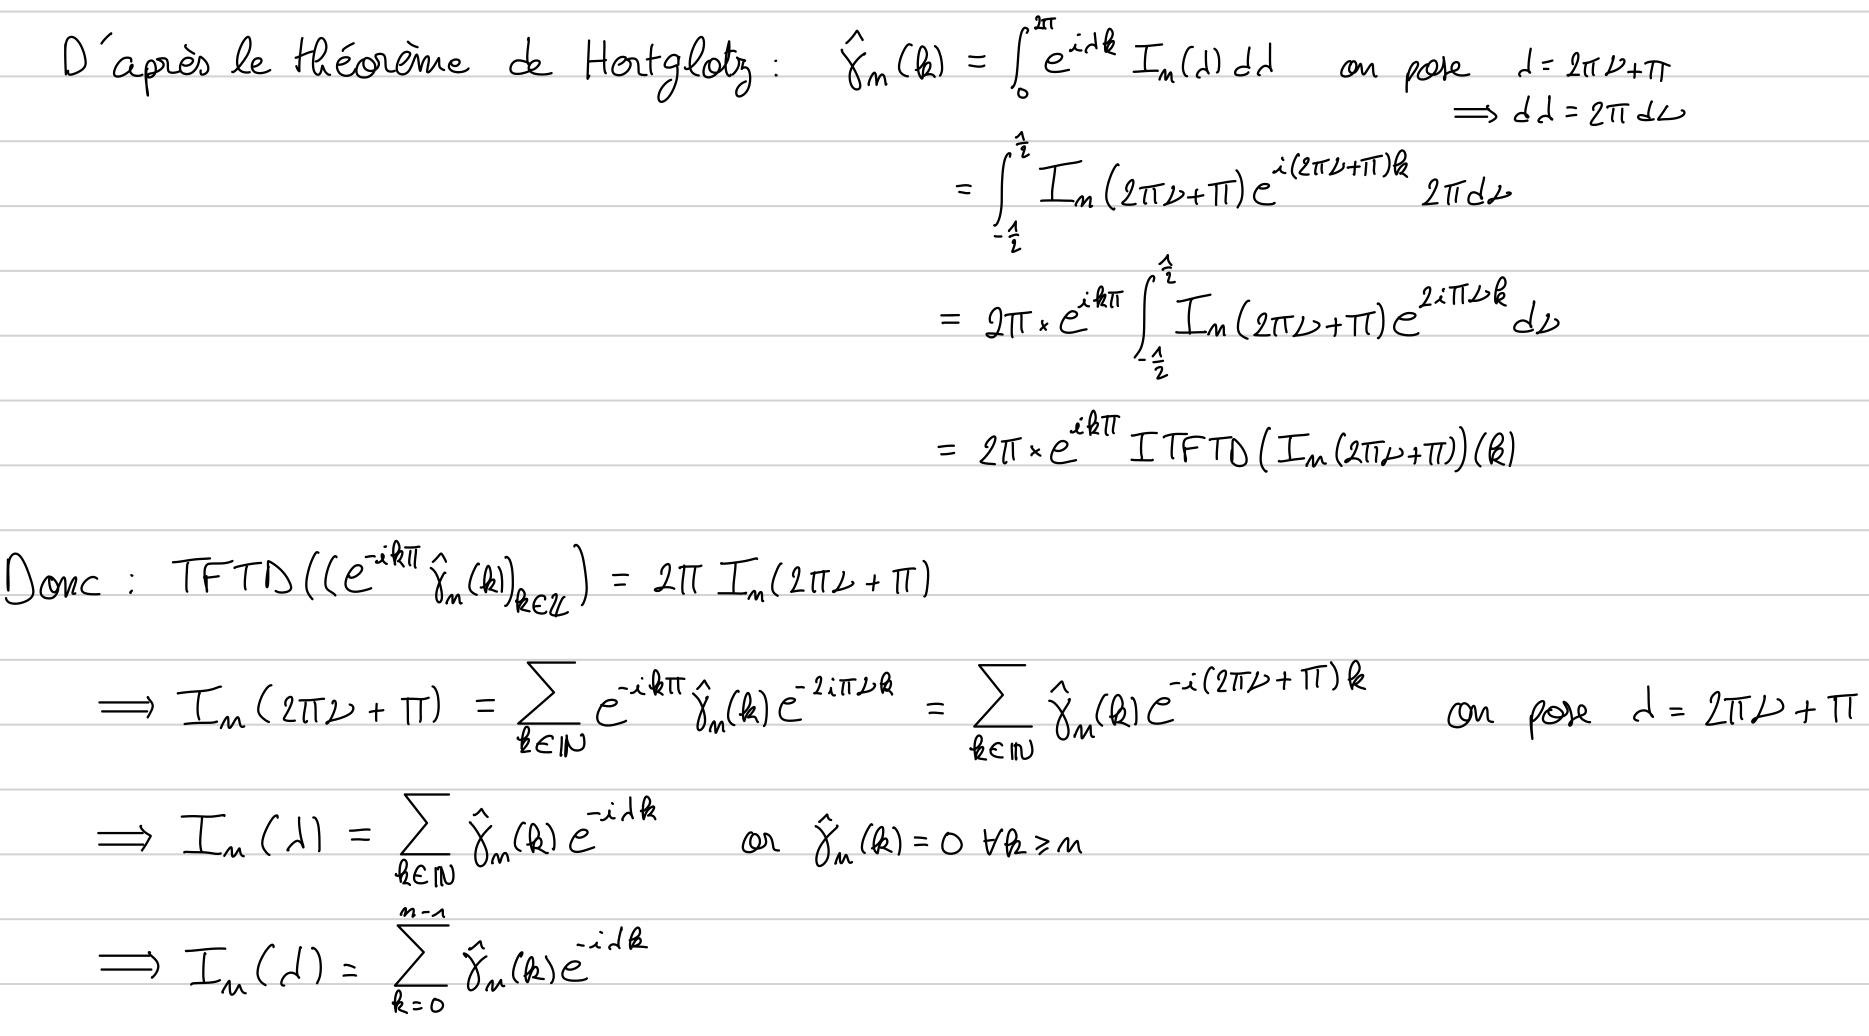

### Question 4 :

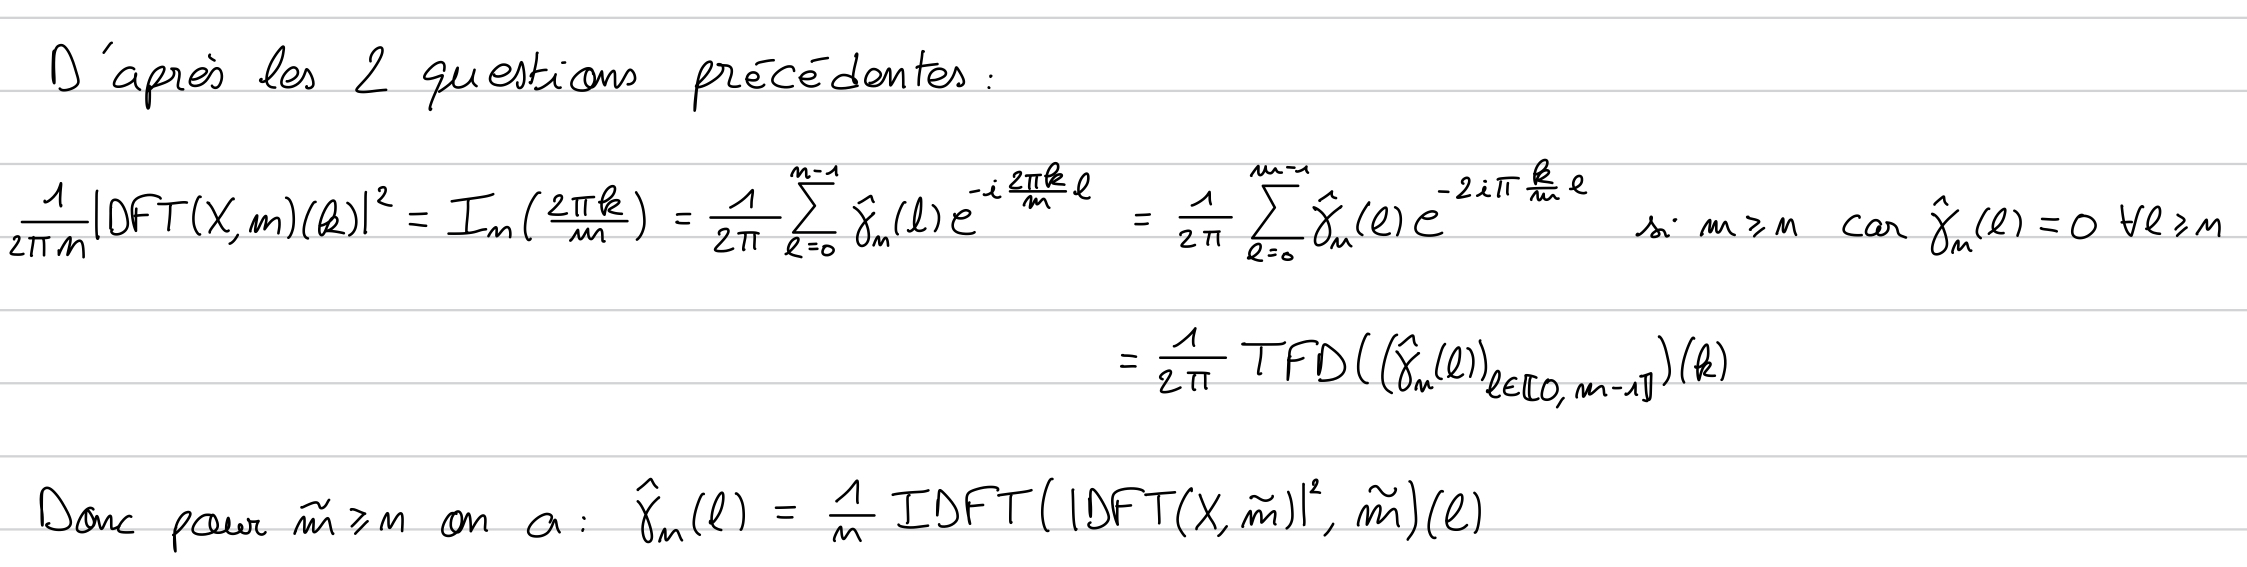

### Question 5:

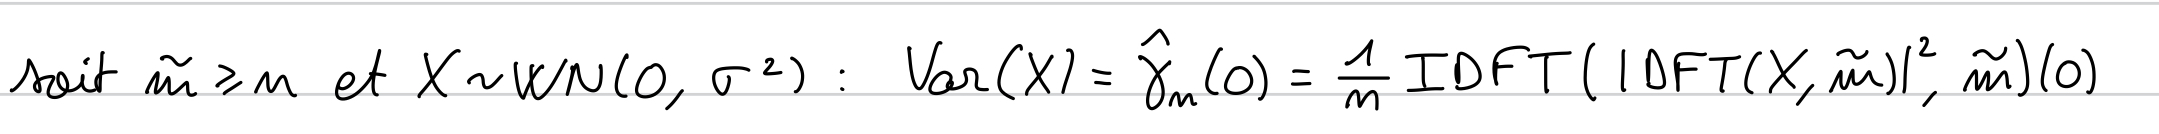

# TP3

The goal of this third partical work is to use an AR(p) process to model a speech signal, and show that this approch is surprisingly powerful despite its simplicity.

The proposed synthesis algorithm divides into several steps.
1. Filter the audio signal to emphasize the highest frequencies (in order to flatten the spectrum and reduce precision issues with FFT computations).
2. Split the signal into several overlapping frames and iterate over them.
    1. Detect if the frame corresponds to noise or to a voiced signal, and estimate the fundamental frequency in the later case.
    2. Estimate the AR(p) coefficients using Yule-Walker equations.
    3. Re-synthetise the frame using the AR(p) coefficients, starting from a white noise in the case of a noisy frame, or a Dirac comb in the case of a voiced frame.
3. Overlap-add the synthesized frames with a Hanning window.
4. Filter the synthesised signal to de-emphasize the highest frequencies.

We propose to implement this algorithm in two parts. First, we will derive the Yule-Walker equations, and test them on synthetic data. Then, we will code the synthesis algorithm and apply it on a real world speech signal.


# 1. Yule-Walker equations

Let us consider a causal, zero-mean, AR(p) process defined by the following recurrent equation: 
$$
X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + \ldots + \phi_p X_{t-p} + Z_{t}
$$
where $\{Z_t , t \in \mathbb{Z}\}$ is a weak white noise with variance $\sigma^2$.

1. Show that, $\forall h \geq 1, \mathbb{E}[X_{t-h}Z_t]=0$.
2. Deduce a recurrent relation between $\gamma(h)$ and $\gamma(h-1),\gamma(h-2),\ldots,\gamma(h-p)$, for $h \geq 1$.
3. We consider separately the case $h=0$: find a new relationship between $\gamma(0)$ and $\gamma(-1),\gamma(-2),\ldots,\gamma(-p)$.
4. Put these relationships in matrix form:
\begin{equation}
\Gamma_{p+1}[1 \; -\phi_1 \; \ldots \; -\phi_p]^T = [\sigma_2 \; 0 \; \ldots \; 0]^T 
\end{equation}
where $\Gamma_{p+1}$ is a suitable Toeplitz matrix that you have to determine.

# 2. Evaluation on synthetic data

We will now evaluate equation $(1)$ on a synthetically generated AR(p) process.

1. Generate n=1000 samples of an AR(4) process.
2. Estimate $\Gamma_{p+1}$ using these samples.
3. Use equation $(1)$ to estimate $\sigma^2$ and the coefficients $\phi_1,\phi_2,\ldots,\phi_p$. Compute the relative error between the estimated and the true coefficients.
4. Estimate power spectral distribution of the synthesized signal. Compare with the theoretical distribution obtained from the poles of $1/\Phi(z^{-1})$.

# 3. Speech modeling

We will now implement the synthesis algorithm and evaluate it on a speech signal. 

A code template is provided below. We will use the file audio.wav to test the algorithm. 


LIsten to the original and synthesized signal by using any audio player. Try to modify the pitch of the synthesised signal and listen to the result.


## 1.Yule-Walker equations :

### Question 1 :

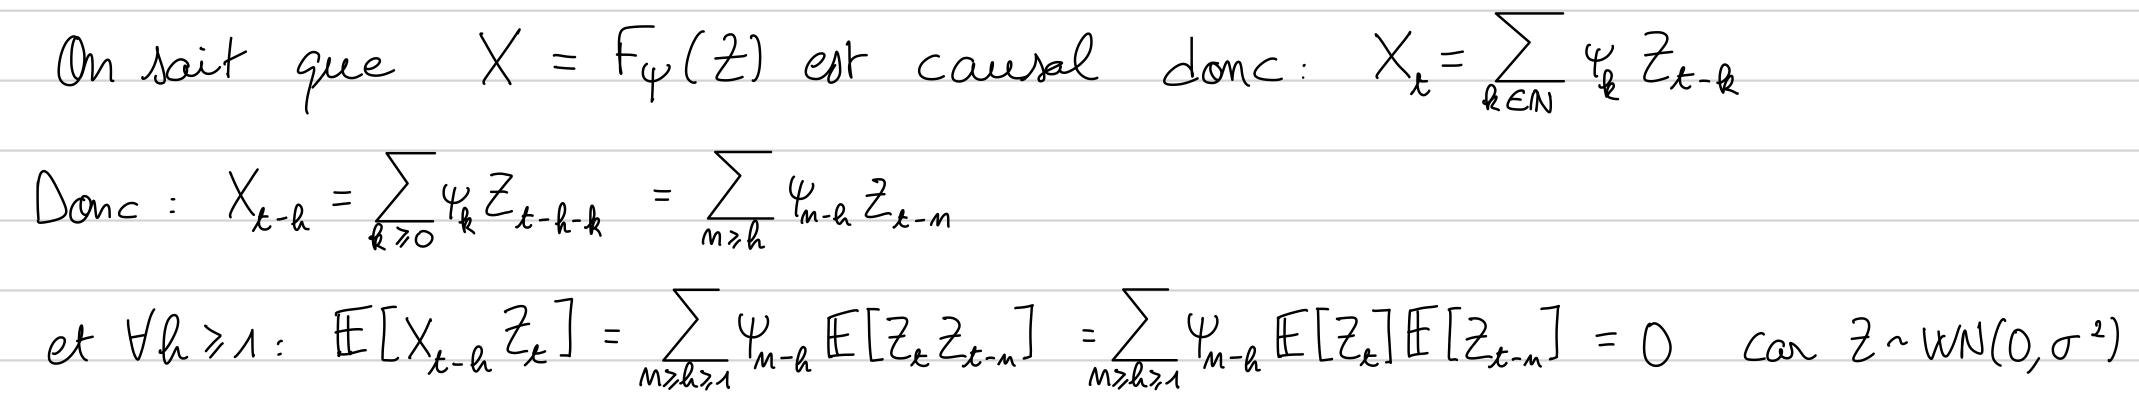

### Question 2 :

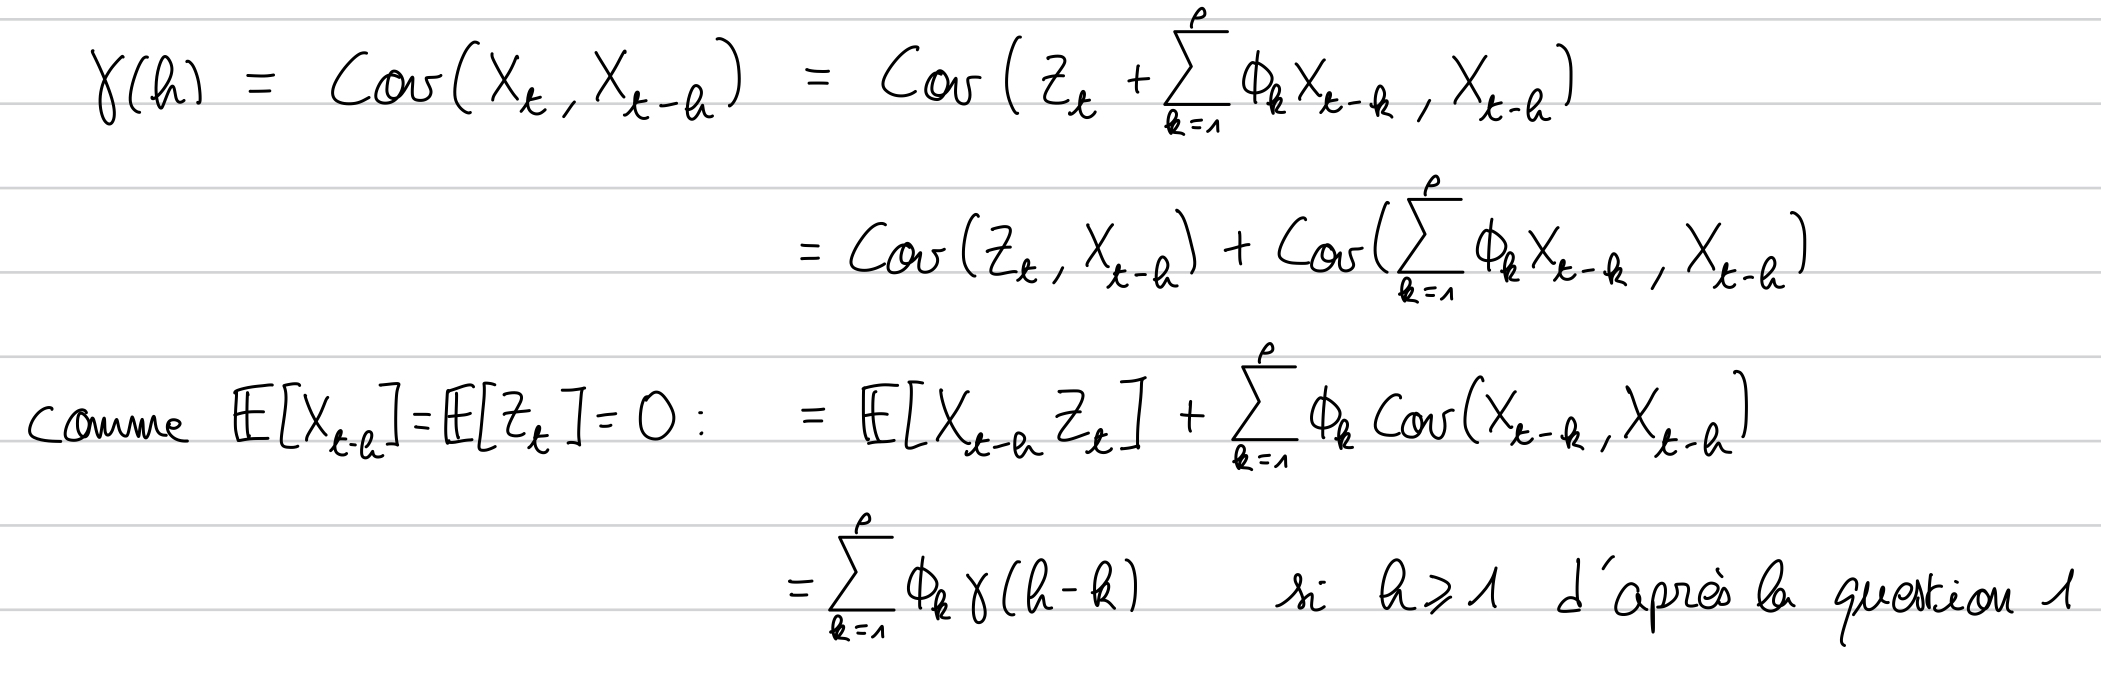

### Question 3 :

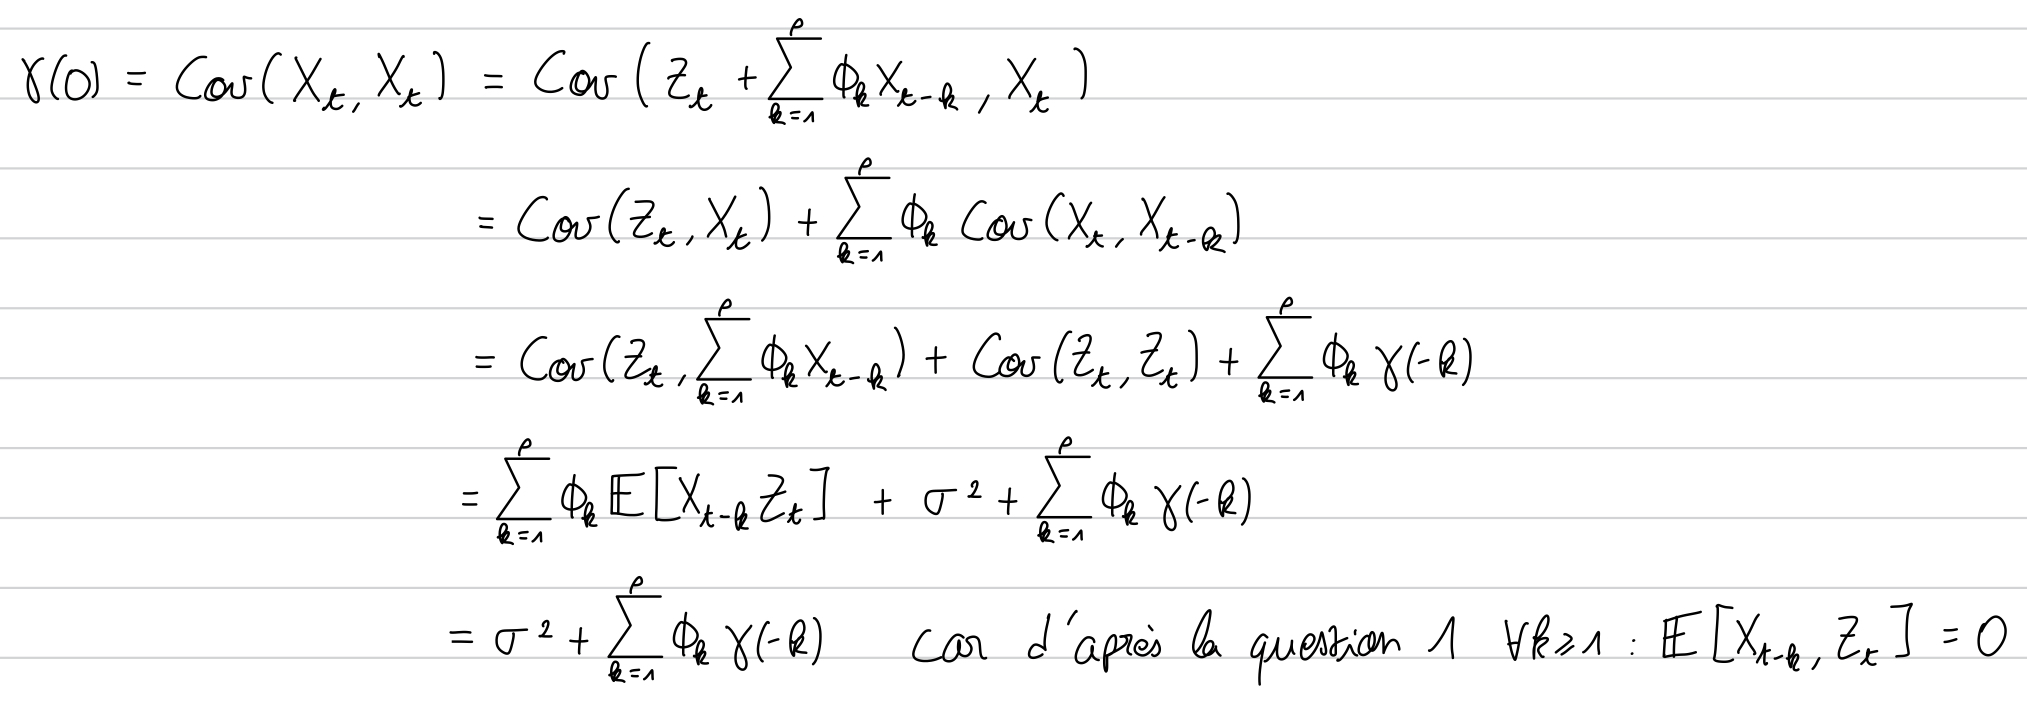

### Question 4 :

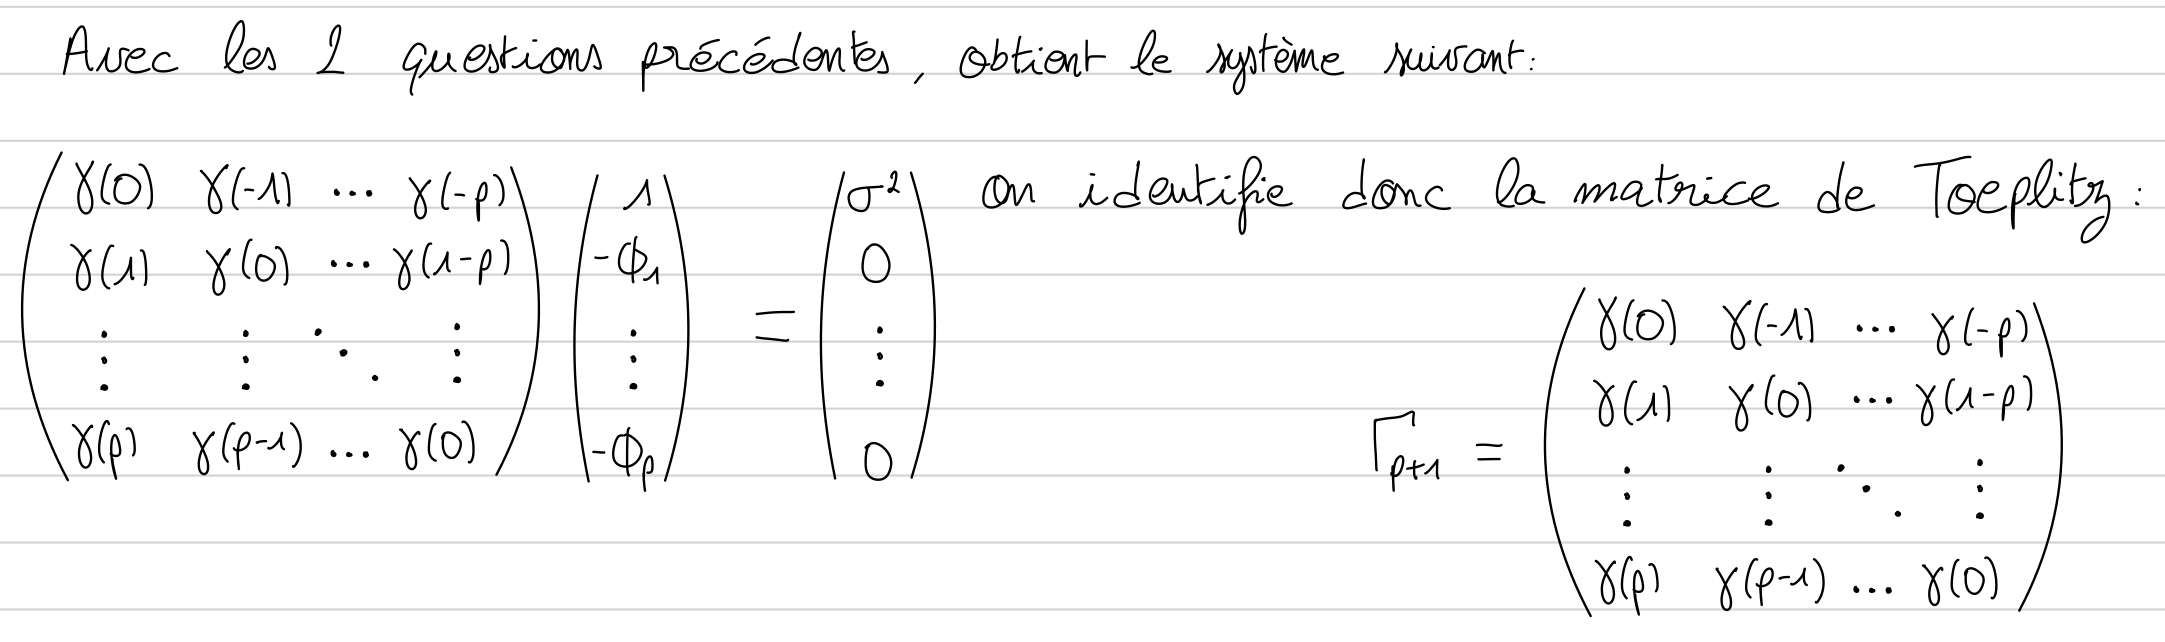

## 2. Evaluation on synthetic data

### Question 1 :

In [22]:
import numpy as np
import matplotlib.pyplot as plt

In [23]:
p = 4
phi = np.array([1, -0.7, 0.3, -0.2])
n = 1000
sigma = 0.5

In [24]:
def samples_AR(p, phi, n, sigma):
    x = np.zeros(n + p)
    for i in range(p, n + p):
        x[i] = np.sum(x[i-p:i] * np.flip(phi)) + np.random.normal(0,np.sqrt(sigma))
    return x[p:]

In [25]:
x = samples_AR(p, phi, n, sigma)

### Question 2 :

In [26]:
def autocovariance_empirique(x, h):
    n = len(x)
    mu = np.mean(x)
    return np.sum((x[:n-h] - mu) * np.conj(x[h:n] - mu)) / n

def toeplitz_matrix(x,p,autocovariances = np.array([])):
    if not autocovariances.any():
        autocovariances = [autocovariance_empirique(x, h) for h in range(p)]
    toeplitz_matrix = np.zeros((p, p))
    for i in range(p):
        for j in range(i+1):
            toeplitz_matrix[i, j] = autocovariances[abs(i - j)]
    toeplitz_matrix += toeplitz_matrix.T - np.diag(np.diag(toeplitz_matrix))
    return toeplitz_matrix

In [27]:
gamma = toeplitz_matrix(x, p)

### Question 3 :

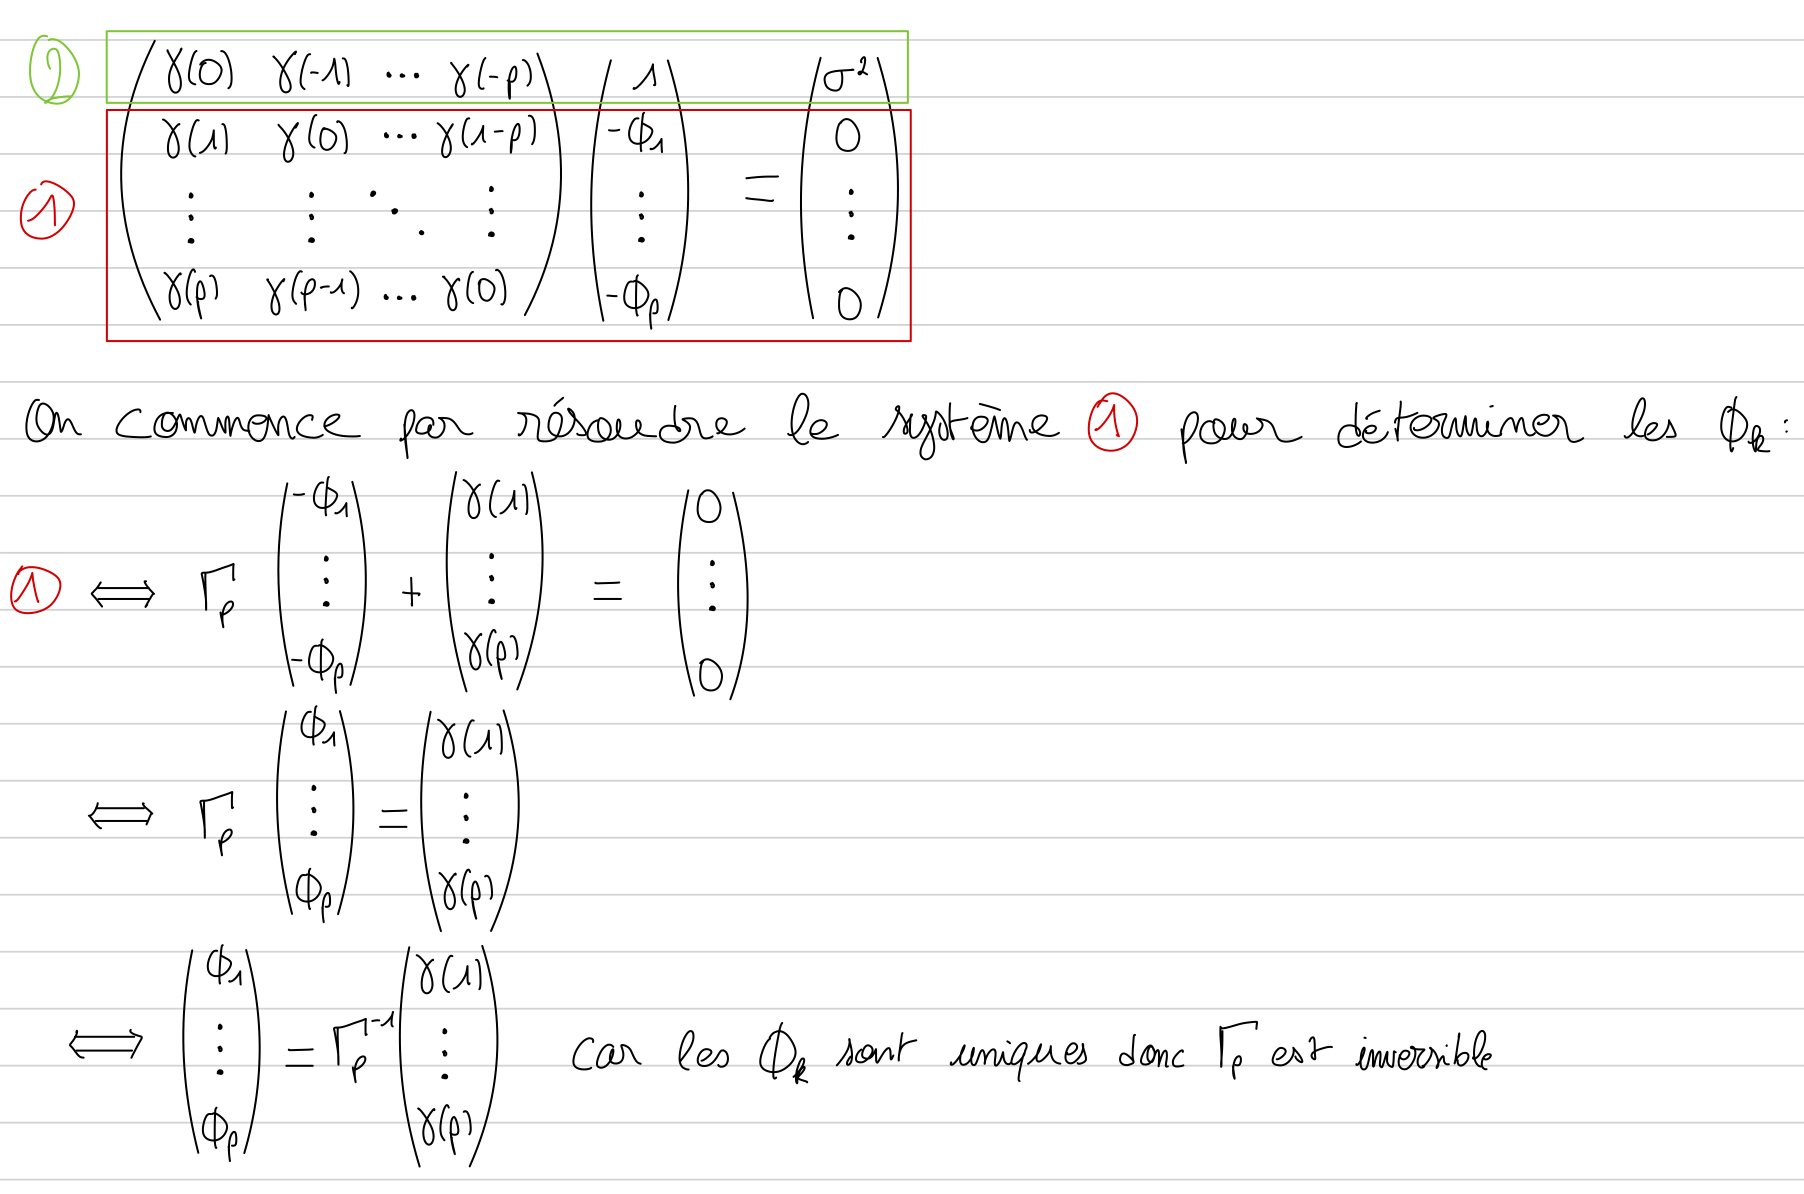

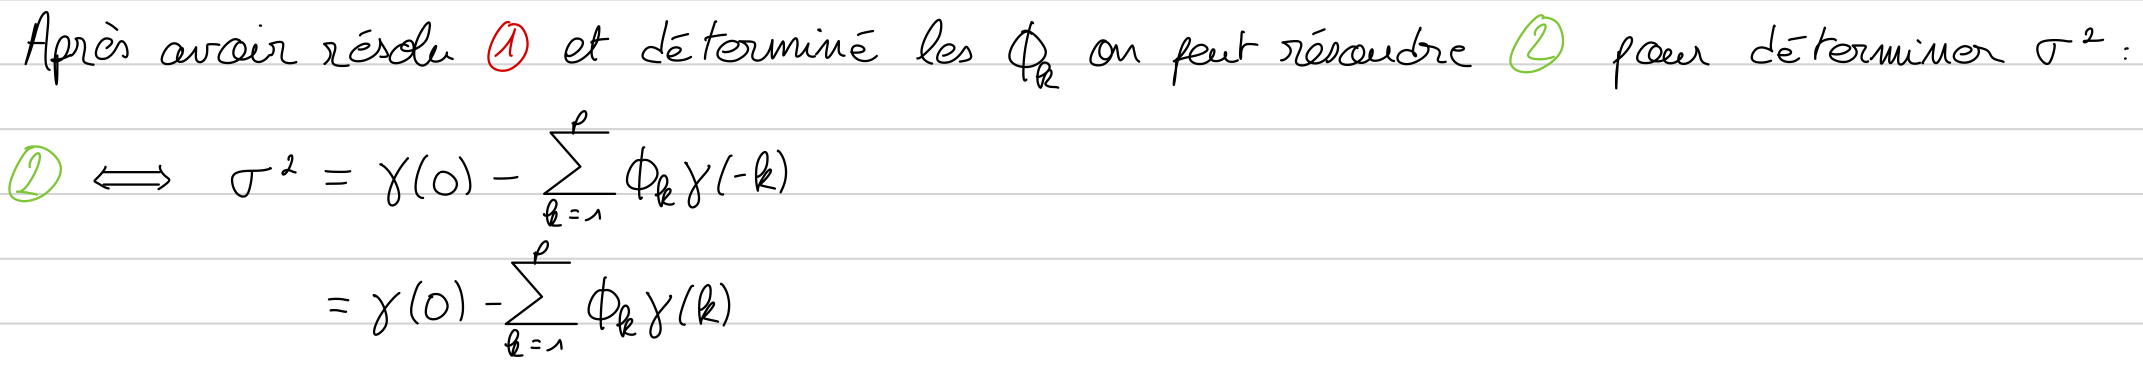

In [28]:
autocovs = np.array([autocovariance_empirique(x, h) for h in range(1, p + 1)])

phi_estimation = np.linalg.solve(gamma, autocovs)

erreur_phi = np.linalg.norm(phi_estimation - phi)/np.linalg.norm(phi)

print("Coefficients estimés phi:", phi_estimation)
print("Coefficients réels phi:", phi)
print("Erreur relative sur les coefficients:", erreur_phi)

Coefficients estimés phi: [ 0.98412452 -0.69974749  0.31984354 -0.22294413]
Coefficients réels phi: [ 1.  -0.7  0.3 -0.2]
Erreur relative sur les coefficients: 0.02690052291041951


In [29]:
sigma_estimation = autocovariance_empirique(x,0) - np.matmul(phi_estimation,autocovs)
erreur_sigma = np.abs((sigma_estimation-sigma)/sigma)

print("Variance estimée:", sigma_estimation)
print("Variance réelle:", sigma)
print("Erreur relative sur la variance:", erreur_sigma)

Variance estimée: 0.4955273086581121
Variance réelle: 0.5
Erreur relative sur la variance: 0.00894538268377576


### Question 4 :

In [30]:
def densite_spectrale(phi, sigma, n_fft=512):
    phi_with_1 = np.concatenate(([1], -phi))
    #Spectre sur [0,2pi]
    freqs = np.fft.fftfreq(n_fft, d=1)
    fft = np.fft.fft(phi_with_1, n=n_fft)
    #On met les fréquences de -1/2 à 1/2
    freqs_shifted = np.fft.fftshift(freqs)
    fft_shifted = np.fft.fftshift(fft)
    dsp = (sigma)/(2*np.abs(fft_shifted)**2)
    return freqs_shifted, dsp


def periodogram(X):
    n = len(X)
    periodogram = (np.abs(np.fft.fft(X - np.mean(X)))**2)/(2*np.pi*n)
    freqs = np.fft.fftfreq(n, d=1)
    return np.fft.fftshift(freqs), np.fft.fftshift(periodogram)

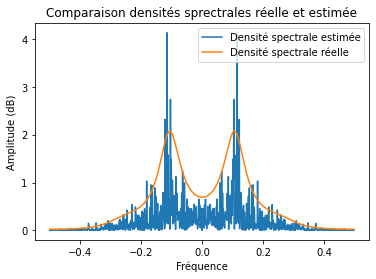

In [31]:
freqs_estimation, dsp_estimation = periodogram(x)
freqs, dsp = densite_spectrale(phi, sigma)

plt.plot(freqs_estimation,dsp_estimation, label='Densité spectrale estimée')
plt.plot(freqs,dsp, label='Densité spectrale réelle')

plt.title("Comparaison densités sprectrales réelle et estimée")
plt.xlabel("Fréquence")
plt.ylabel("Amplitude (dB)")
plt.legend()
plt.show()


On remarque que l'estimation de la DSP est très proche de la valeur réelle mais avec certaines valeurs abérantes

## 3. Speech modeling

In [32]:
## imports

import librosa
import soundfile as sf
import scipy
import numpy as np
import math
from collections import defaultdict
from tqdm import tqdm
import matplotlib.animation
import matplotlib.pyplot as plt
from IPython.display import HTML

In [33]:
## hyperparameters

sampling_rate = 8000 # (Hz)
frame_duration = 0.04 # duration of the analysis frames (seconds)
overlap_ratio = 0.5 # overlap ratio between two consecutive analysis frames
p = 12 # AR(p) model order
f_min = 80 # minimum frequency for pitch detection (Hz)
f_max = 400 # maximum frequency for pitch detection Hz)
pitch_detection_threshold = 0.5 # threshold for pitch detection

In [34]:
## synthesis

# load audio
x = librosa.load('audio.wav', sr=sampling_rate)[0]

# pre-emphasis filtering
x = scipy.signal.lfilter([1, -0.98], [1], x)

# handy variables
n_frame = math.floor(len(x) / (sampling_rate * frame_duration * (1 - overlap_ratio))) - 1 # discard last frame
frame_length = int(sampling_rate * frame_duration)
min_period = math.floor(sampling_rate / f_max)
max_period = math.ceil(sampling_rate / f_min)
synthesis = np.zeros(len(x))
log_dict = defaultdict(list)

# loop over frames
for frame_index in tqdm(range(n_frame)):

    # extract frame
    start = int(frame_index * sampling_rate * frame_duration * (1 - overlap_ratio))
    end = start + frame_length
    frame = x[start:end]

    # detect pitch
    auto_covariance = np.fft.irfft(np.abs(np.fft.rfft(frame - np.mean(frame), (2*frame_length-1)))**2 / frame_length)[:frame_length]
    pitch, max_value = auto_covariance[min_period:].argmax() + min_period, auto_covariance[min_period:].max() / auto_covariance[0]
    if (pitch > max_period) or (max_value * frame_length / (frame_length - pitch) < pitch_detection_threshold): # detect silent frame 
        pitch = 0
    
    # estimate AR(p) coefficients
    gamma = toeplitz_matrix(frame, p,autocovariances=auto_covariance[:p])
    v = np.array([1 if k==0 else 0 for k in range(p+1)])
    coefficient = np.linalg.solve(gamma, auto_covariance[1:p+1])
    sigma = np.abs(autocovariance_empirique(x,0) - np.matmul(coefficient,auto_covariance[1:p+1]))
    coefficient = np.concatenate((np.array([1]),-coefficient))

    # re-synthetise frame
    if pitch == 0:
        noise = np.random.normal(0, np.sqrt(sigma), frame_length + p)
        frame_r = scipy.signal.lfilter([1], coefficient, noise)
    else:
        dirac_comb = np.zeros(frame_length + p)
        dirac_comb[::pitch] = 1
        frame_r = scipy.signal.lfilter([1], coefficient, dirac_comb)
    frame_r = frame_r[p:]
    normalization_factor = np.sqrt(sigma / np.var(frame_r))
    frame_r = normalization_factor * frame_r[:frame_length] 

    # overlap-add
    synthesis[start:end] += frame_r * np.hanning(frame_length)

    # compute power spectral density (for logging purposes)
    original_psd = np.abs(np.fft.rfft(frame))**2 / frame_length
    synthesis_psd = np.abs(np.fft.rfft(frame_r))**2 / frame_length

    # log
    log_dict["frame"].append(frame)
    log_dict["pitch"].append(pitch)
    log_dict["sigma"].append(sigma)
    log_dict["coefficient"].append(coefficient)
    log_dict["frame_r"].append(frame_r)
    log_dict["original_psd"].append(original_psd)
    log_dict["synthesis_psd"].append(synthesis_psd)

# de-emphasis filtering
synthesis = scipy.signal.lfilter([1], [1, -0.98], synthesis)

# log
sf.write('synthesis.wav', synthesis, sampling_rate)
log_dict["synthesis"].append(synthesis)
log_dict = {k: np.array(v) for k, v in log_dict.items()}

100%|██████████| 279/279 [00:00<00:00, 1832.32it/s]


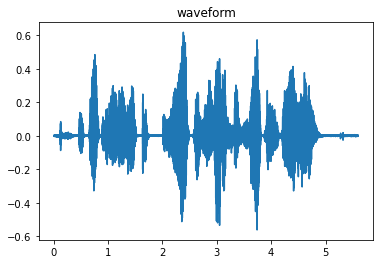

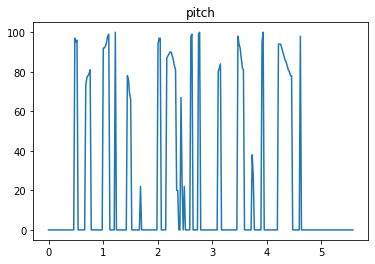

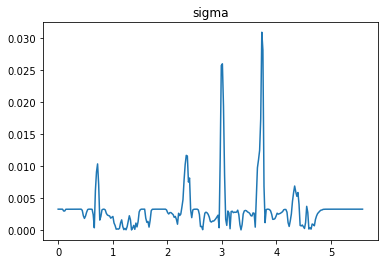

In [35]:
## plot

# time axis for plotting
sample_time = np.linspace(0, len(x)/sampling_rate, len(x))
frame_time = np.linspace(0, n_frame*frame_duration*(1-overlap_ratio), n_frame)

# waveform
plt.title("waveform")
plt.plot(sample_time, x)
plt.show()

# pitch
plt.title("pitch")
plt.plot(frame_time, log_dict["pitch"])
plt.show()

# variance
plt.title("sigma")
plt.plot(frame_time, log_dict["sigma"])
plt.show()

# power spectral density
fig, ax = plt.subplots()
fig.suptitle("estimated & theoretical spectral density")
y_min = min(log_dict["original_psd"].min(), log_dict["synthesis_psd"].min())
y_max = max(log_dict["original_psd"].max(), log_dict["synthesis_psd"].max())
def animate(i):
    ax.cla()
    ax.set_ylim([y_min-0.1, y_max+0.1])
    ax.plot(log_dict["original_psd"][i], label="original_psd")
    ax.plot(log_dict["synthesis_psd"][i], label="synthesis_psd")
animation = matplotlib.animation.FuncAnimation(fig, animate, frames=len(log_dict["original_psd"]))
display(HTML(animation.to_jshtml()))
plt.close()